<a href="https://colab.research.google.com/github/Csodo/Teme-probabilitati/blob/master/German_traffic_signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kagglehub

In [3]:
import kagglehub

path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/gtsrb-german-traffic-sign


In [4]:

import numpy as np
import pandas as pd


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


A streamkimeneten csak az utolsó 5000 sor látható.
/kaggle/input/gtsrb-german-traffic-sign/train/9/00009_00007_00026.png
/kaggle/input/gtsrb-german-traffic-sign/train/9/00009_00002_00002.png
/kaggle/input/gtsrb-german-traffic-sign/train/9/00009_00035_00008.png
/kaggle/input/gtsrb-german-traffic-sign/train/9/00009_00034_00019.png
/kaggle/input/gtsrb-german-traffic-sign/train/9/00009_00039_00015.png
/kaggle/input/gtsrb-german-traffic-sign/train/9/00009_00041_00025.png
/kaggle/input/gtsrb-german-traffic-sign/train/9/00009_00005_00005.png
/kaggle/input/gtsrb-german-traffic-sign/train/9/00009_00021_00028.png
/kaggle/input/gtsrb-german-traffic-sign/train/9/00009_00018_00006.png
/kaggle/input/gtsrb-german-traffic-sign/train/9/00009_00022_00010.png
/kaggle/input/gtsrb-german-traffic-sign/train/9/00009_00017_00016.png
/kaggle/input/gtsrb-german-traffic-sign/train/9/00009_00036_00028.png
/kaggle/input/gtsrb-german-traffic-sign/train/9/00009_00013_00016.png
/kaggle/input/gtsrb-german-traffic-sign

In [16]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset

In [17]:
train_dir = '/kaggle/input/gtsrb-german-traffic-sign/train'

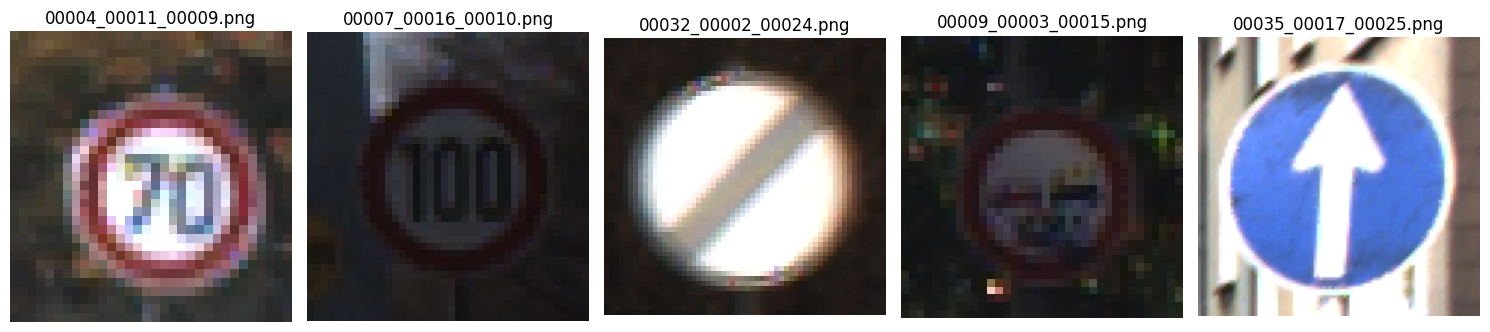

In [19]:
def show_random_images(base_dir, num_images=5):
    all_images = []
    for root, dirs, files in os.walk(base_dir):
        for f in files:
            if f.lower().endswith('.png'):
                all_images.append(os.path.join(root, f))
    sample_files = random.sample(all_images, num_images)

    plt.figure(figsize=(15, 5))
    for idx, filepath in enumerate(sample_files):
        img = Image.open(filepath)
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img)
        plt.title(os.path.basename(filepath))
        plt.axis('off')
    plt.tight_layout()
    plt.show()
show_random_images(train_dir)


In [21]:
all_file_paths = []
all_labels     = []

for root, dirs, files in os.walk(train_dir):
    label = int(os.path.basename(root)) if os.path.basename(root).isdigit() else None
    if label is not None:
        for f in files:
            if f.lower().endswith('.png'):
                all_file_paths.append(os.path.join(root, f))
                all_labels.append(label)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_file_paths, all_labels, test_size=0.2, random_state=42
)

print(f"Număr total imagini: {len(all_file_paths)}")
print(f"– Train: {len(train_paths)} imagini")
print(f"– Val:   {len(val_paths)} imagini")

Număr total imagini: 39209
– Train: 31367 imagini
– Val:   7842 imagini


In [32]:
from torchvision import transforms
from torch.utils.data import Dataset

class GTSRBDataset(Dataset):
    def __init__(self, file_paths, labels=None, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        else:
            return image, os.path.basename(img_path)


In [33]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = GTSRBDataset(train_paths, train_labels, transform)
val_dataset   = GTSRBDataset(val_paths, val_labels, transform)

test_dir = '/kaggle/input/gtsrb-german-traffic-sign/test'

test_file_paths = []
for fname in os.listdir(test_dir):
    if fname.lower().endswith(('.ppm', '.png')):
        test_file_paths.append(os.path.join(test_dir, fname))

test_dataset = GTSRBDataset(test_file_paths, labels=None, transform=transform)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)


In [34]:
class GTSRBCNN(nn.Module):
    def __init__(self):
        super(GTSRBCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),      # 224→112
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),      # 112→56
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)       # 56→28
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),            # 128×28×28 = 100 352
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 43)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [35]:
from torchvision import models

class FineTunedResNetGTSRB(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.resnet18(pretrained=True)

        for param in self.base_model.parameters():
            param.requires_grad = False

        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 43)
        )

    def forward(self, x):
        return self.base_model(x)


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GTSRBCNN().to(device)
# model = FineTunedResNetGTSRB().to(device)


In [37]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FineTunedResNetGTSRB().to(device)


In [38]:
# model.load_state_dict(torch.load(weights_path, map_location=device))

In [39]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model has {count_parameters(model):,} trainable parameters.")

Model has 142,379 trainable parameters.


In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [41]:
epochs = 5
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [42]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct = 0.0, 0
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for images, labels in train_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            train_loop.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)

        model.eval()
        val_loss, val_correct = 0.0, 0
        val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
        with torch.no_grad():
            for images, labels in val_loop:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_loop.set_postfix(val_loss=loss.item())

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} => Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


In [44]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, device, epochs=5
)

Epoch 1/5 => Train Loss: 1.5237, Acc: 0.5477 | Val Loss: 0.8591, Acc: 0.7221


Epoch 2/5 => Train Loss: 0.9217, Acc: 0.7026 | Val Loss: 0.6239, Acc: 0.7976


Epoch 3/5 => Train Loss: 0.7773, Acc: 0.7460 | Val Loss: 0.5305, Acc: 0.8303


Epoch 4/5 => Train Loss: 0.6879, Acc: 0.7724 | Val Loss: 0.4932, Acc: 0.8375


Epoch 5/5 => Train Loss: 0.6428, Acc: 0.7843 | Val Loss: 0.4458, Acc: 0.8503


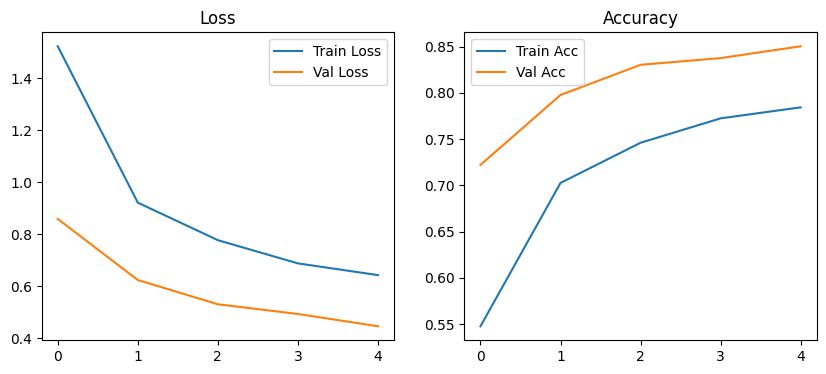

In [45]:
# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()

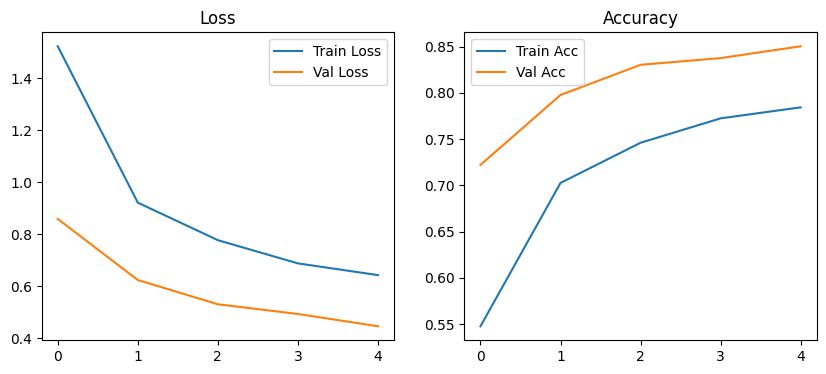

In [46]:
# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()

In [52]:

def plot_top_misclassified(model, dataloader, class_names=None, device='cuda', top_n=5):
    if class_names is None:
        class_names = [str(i) for i in range(43)]

    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            mis_idx = preds != labels
            for i in range(images.size(0)):
                if mis_idx[i]:
                    misclassified.append((images[i].cpu(), preds[i].item(), labels[i].item()))

    examples = misclassified[:top_n]
    if len(examples) == 0:
        print("Nu s-au găsit exemple greșit clasificate.")
        return

    fig, axes = plt.subplots(1, len(examples), figsize=(4 * len(examples), 4))
    fig.suptitle('Top Misclassified', fontsize=16)
    if len(examples) == 1:
        axes = [axes]

    for ax, (img_tensor, pred, true) in zip(axes, examples):
        img = img_tensor.permute(1, 2, 0).numpy()
        img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(f'Pred: {class_names[pred]}\nTrue: {class_names[true]}', fontsize=12)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


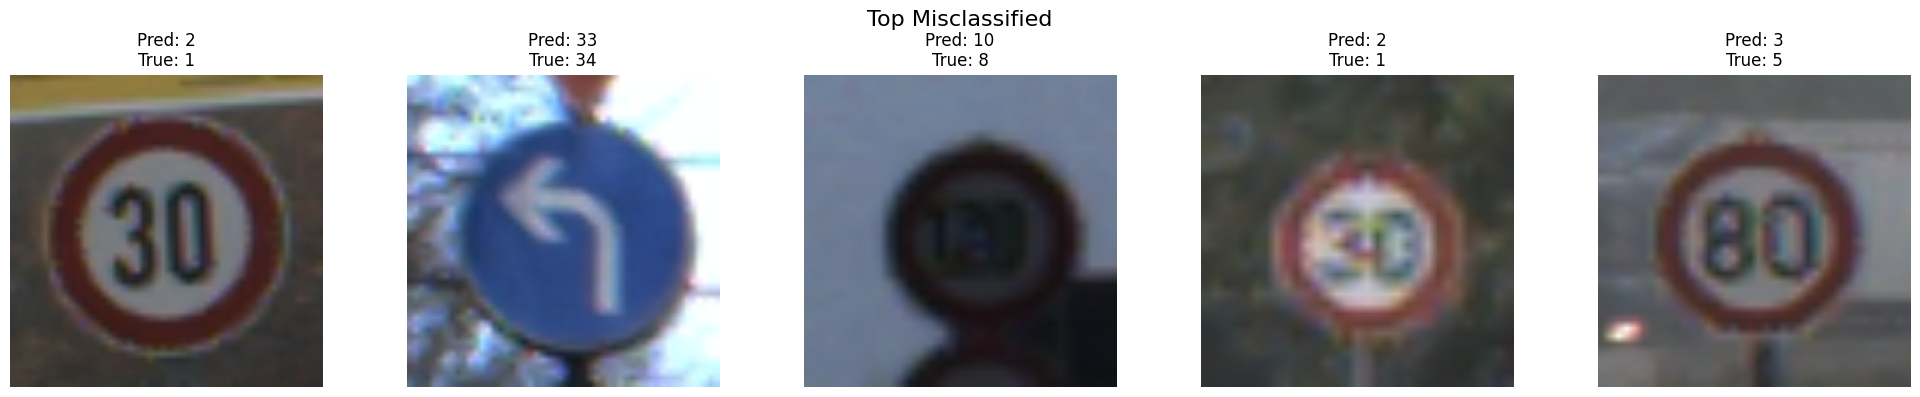

In [53]:
class_names = [str(i) for i in range(43)]
plot_top_misclassified(model, val_loader, class_names, device)

In [57]:

os.makedirs('models', exist_ok=True)
torch.save(model.state_dict(), 'models/cnn_gtsrb_model_weights.pth')
torch.save(model, 'models/cnn_gtsrb_full_model.pth')


In [59]:
os.makedirs('models', exist_ok=True)
torch.save(model.state_dict(), 'models/resnet_gtsrb_model_weights.pth')
torch.save(model, 'models/resnet_gtsrb_full_model.pth')


In [60]:
torch.save(model.state_dict(), "gtsrb_resnet18.pth")